In [15]:
# 한글 깨짐 방지
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [1]:
import pandas as pd
import numpy as np

DATA_PATH = "C:/Users/user/Desktop/데이터분석/05 Project_Final/Data/"

train_tr = pd.read_csv(f"{DATA_PATH}store_train_transactions.csv") # 학습용 구매기록 데이터
train_target = pd.read_csv(f"{DATA_PATH}store_train.csv") # 학습용 정답 데이터
test_tr = pd.read_csv(f"{DATA_PATH}store_test_transactions.csv") # 테스트용 구매기록 데이터
submit = pd.read_csv(f"{DATA_PATH}store_submission.csv") # 제출 양식 데이터

train_tr.shape , train_target.shape , test_tr.shape , submit.shape

((523105, 7), (14940, 2), (441196, 7), (12225, 2))

In [2]:
DATA_PATH = "C:/Users/user/Desktop/데이터분석/05 Project_Final/Feature_csv/"
train_ft = pd.read_csv(f"{DATA_PATH}train_common_v3.1_1106.csv")
test_ft = pd.read_csv(f"{DATA_PATH}test_common_v3.1_1106.csv")

In [4]:
train_ft.drop(columns= "ID", inplace= True)
test_ft.drop(columns= "ID", inplace= True)

In [5]:
cols = train_ft.select_dtypes("object").columns
cols

Index(['주구매지점', '주구매_대분류', '주구매_중분류'], dtype='object')

In [7]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
import category_encoders as ce

# 범주형 변수 원핫인코딩
# enc = OneHotEncoder(handle_unknown = 'ignore')
# enc.fit(train_ft[cols])
# tmp = pd.DataFrame(
#     enc.transform(train_ft[cols]).toarray(),
#     columns = enc.get_feature_names_out()
# )
# train_ft = pd.concat([train_ft,tmp],axis=1).drop(columns=cols)

# tmp = pd.DataFrame(
#     enc.transform(test_ft[cols]).toarray(),
#     columns = enc.get_feature_names_out()
# )
# test_ft = pd.concat([test_ft,tmp],axis=1).drop(columns=cols)

# 범주형 변수 카운트 인코딩
enc = ce.count.CountEncoder()
for col in cols:
    train_ft[f"{col}_cnt"] = enc.fit_transform(train_ft[[col]])
    test_ft[f"{col}_cnt"] = enc.transform(test_ft[[col]])

# 문자열 피처 삭제
train_ft = train_ft.drop(columns=cols)
test_ft = test_ft.drop(columns=cols)

# # Min-Max Scaling
# scaler = StandardScaler()
# scaler.fit(train_ft)
# train_ft[train_ft.columns] = scaler.transform(train_ft)
# test_ft[test_ft.columns] = scaler.transform(test_ft)

# 정답 데이터
target = train_target["target"]

In [9]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, cross_val_score
cv = KFold(5, shuffle= True, random_state= 42)
model = LGBMClassifier(random_state= 42)
scores = cross_val_score(model, train_ft, target, cv= cv, scoring= "f1_macro", n_jobs= -1)
scores.mean()

0.7143727896409139

In [10]:
model.fit(train_ft, target)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5874, number of negative: 9066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 139272
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 1389
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.393173 -> initscore=-0.433995
[LightGBM] [Info] Start training from score -0.433995


LGBMClassifier(random_state=42)

In [18]:
train_ft.iloc[n]

내점일수                        92.000000
구매주기                         3.000000
주말방문비율                       0.189573
평일방문비율                       0.810427
주말방문횟수                      40.000000
                             ...     
공휴일_대분류_케주얼_구두_아동_구매횟수       1.000000
공휴일_대분류_패션잡화_구매횟수            0.000000
주구매지점_cnt                 3999.000000
주구매_대분류_cnt               1057.000000
주구매_중분류_cnt               4226.000000
Name: 3, Length: 1519, dtype: float64

In [19]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_ft)
expected_value = explainer.expected_value

n = 100
shap.initjs()   # force_plot이 자바스크립트 사용해서 같이 실행해줌
shap.force_plot(expected_value, shap_values[n], train_ft.iloc[n], link = "logit")

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


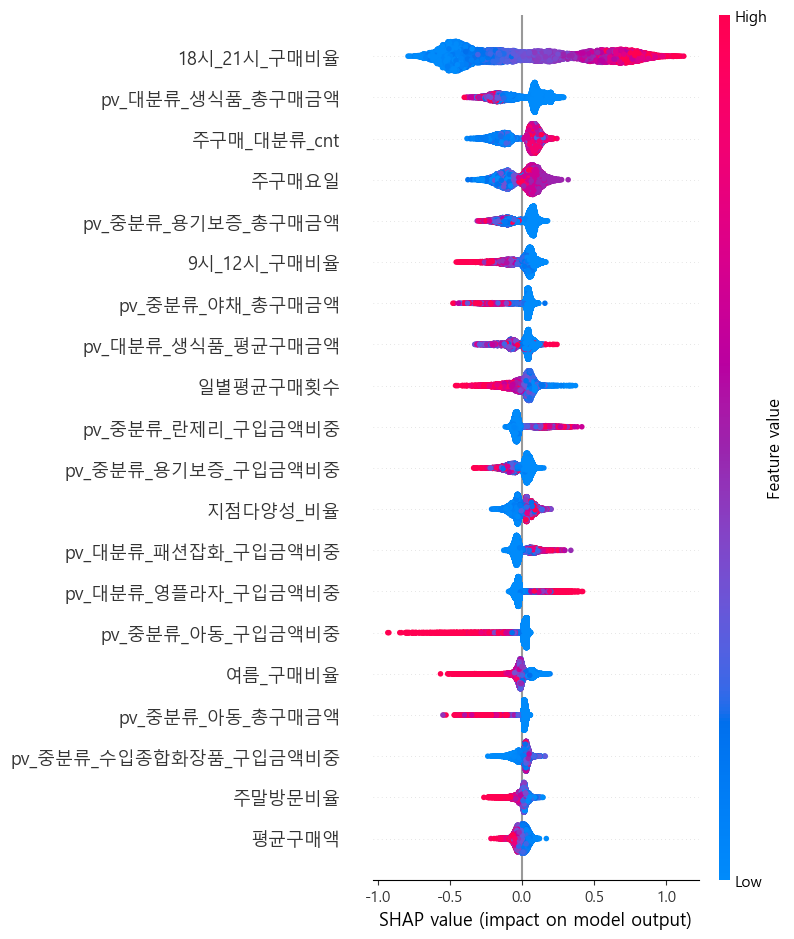

In [16]:
shap.summary_plot(shap_values, train_ft)


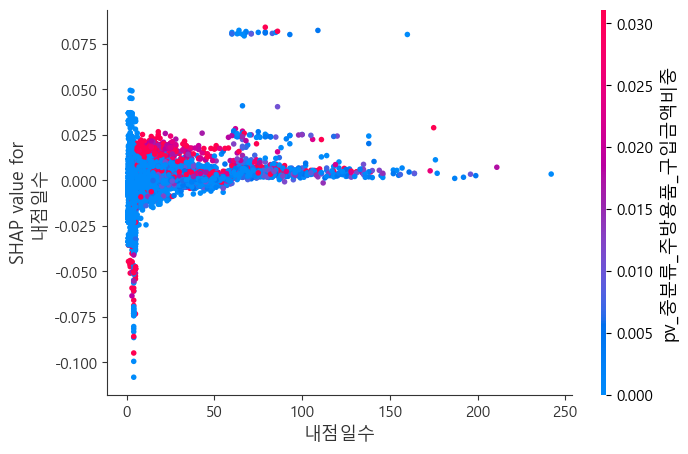

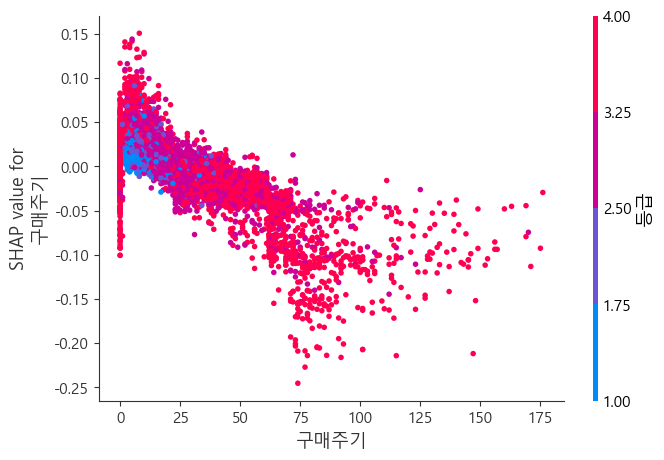

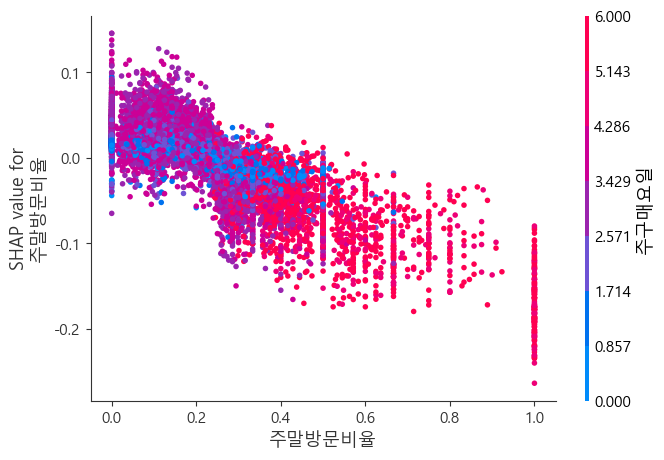

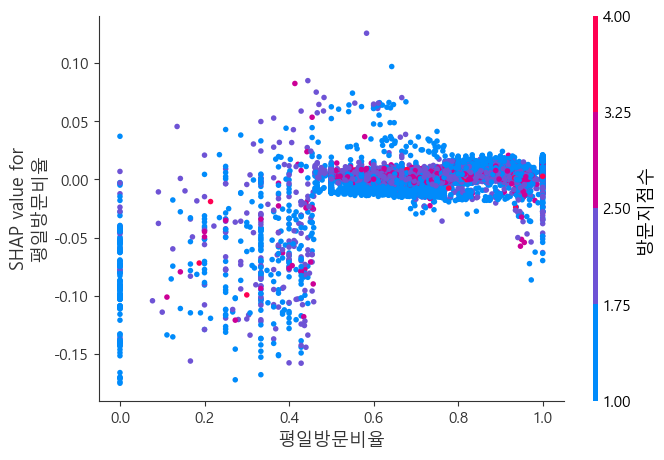

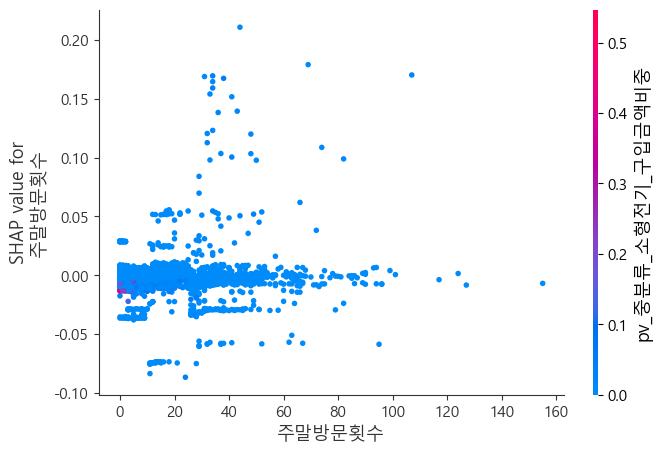

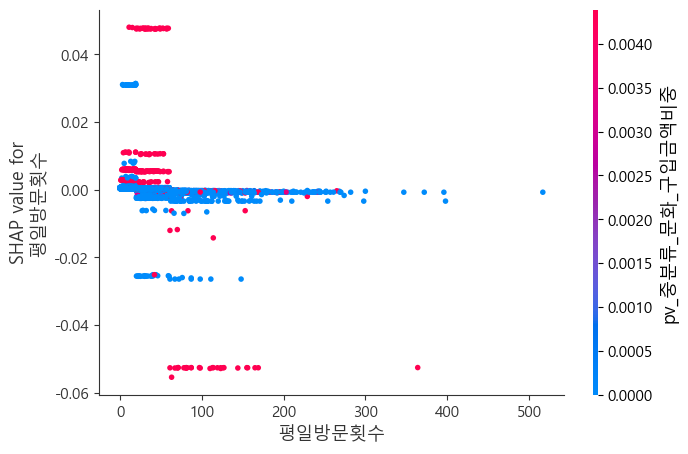

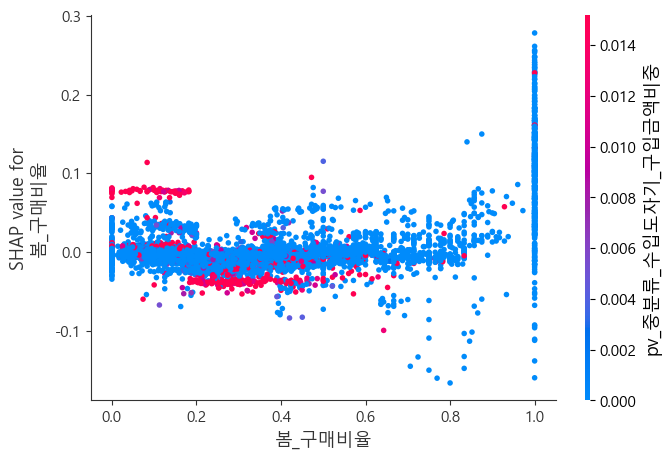

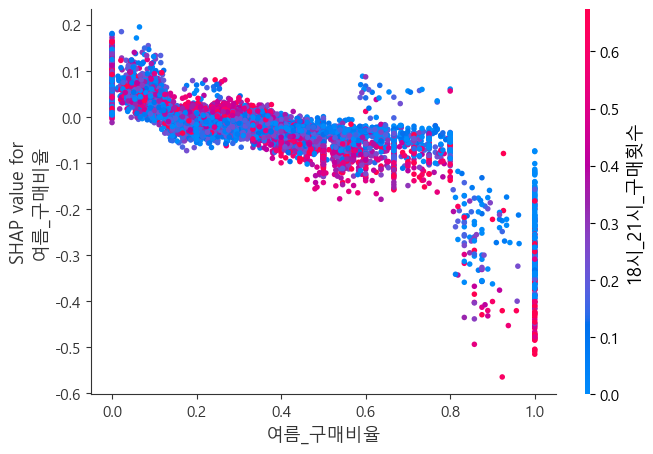

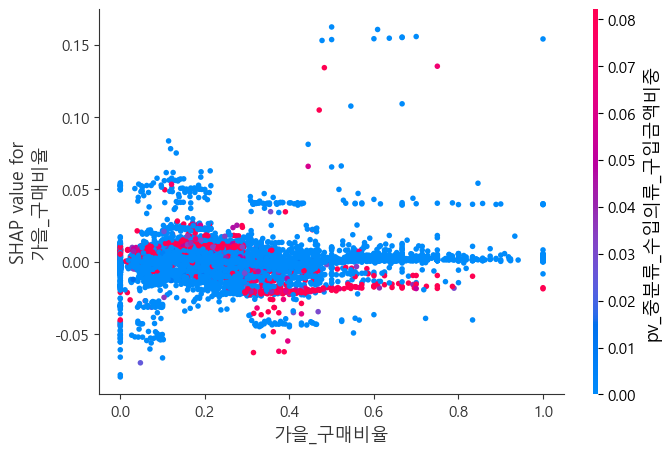

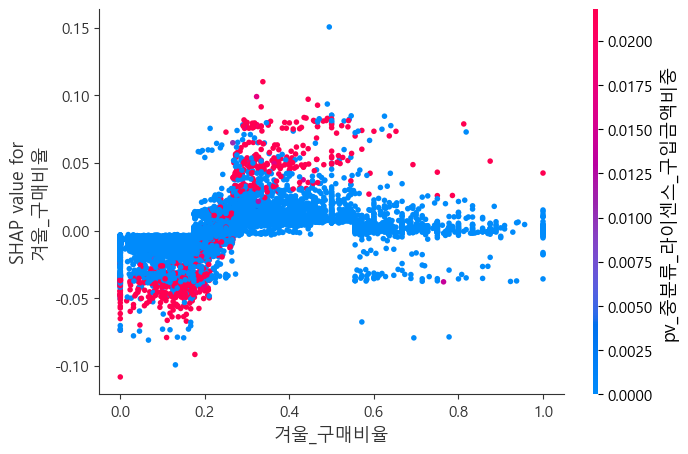

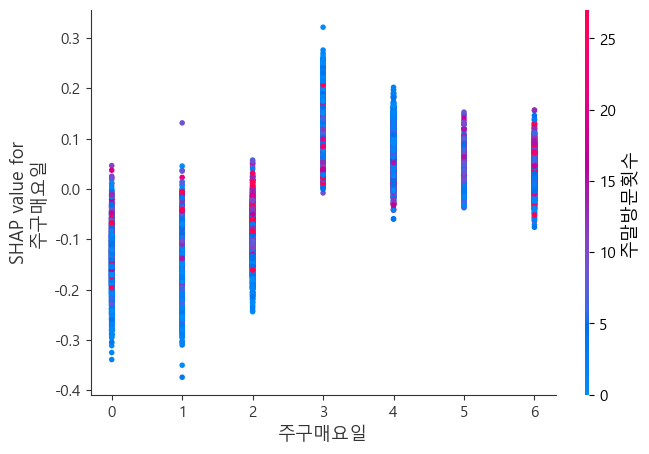

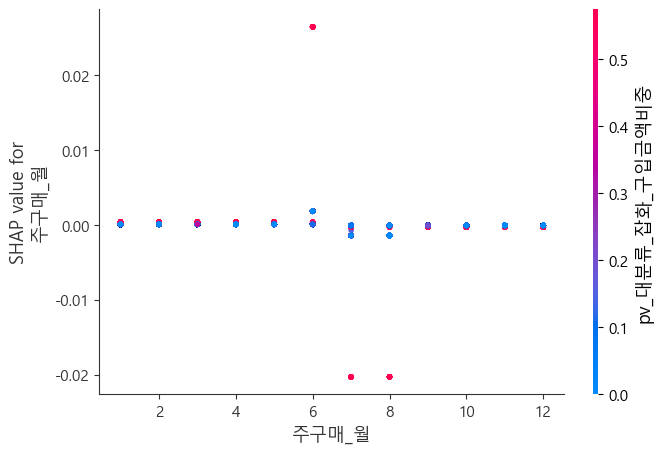

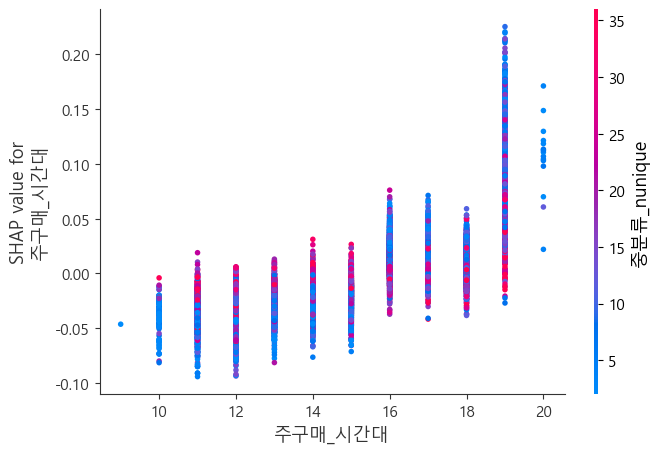

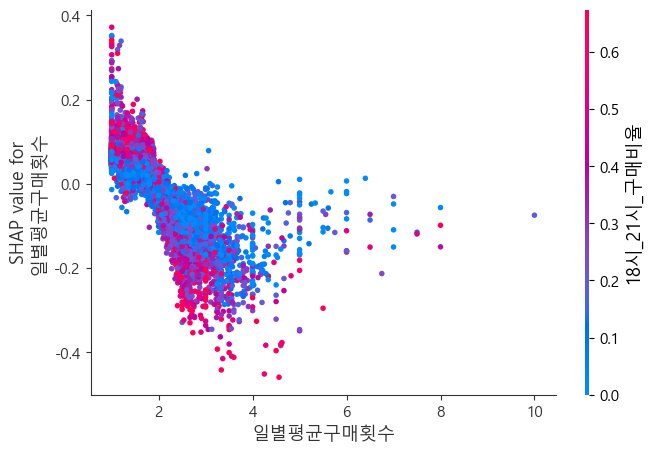

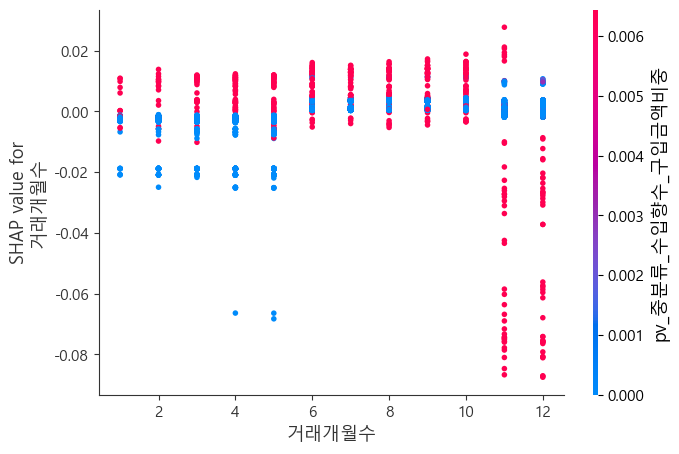

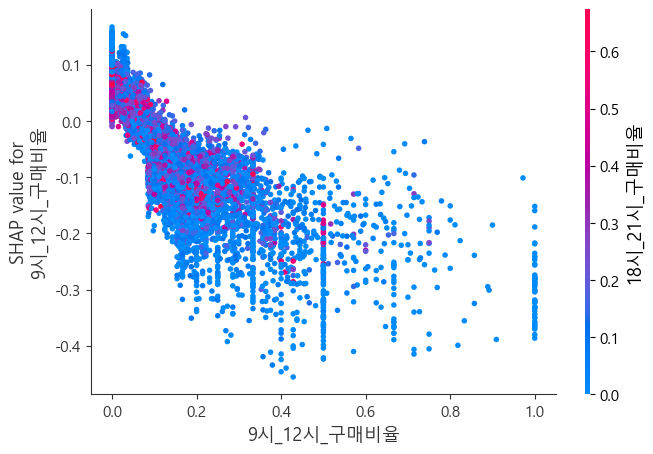

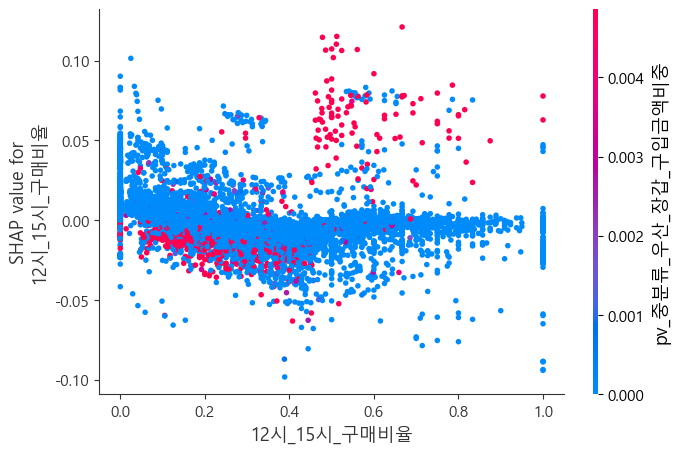

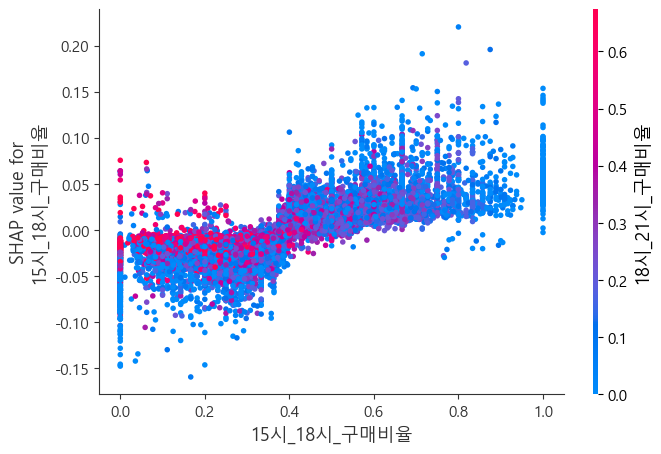

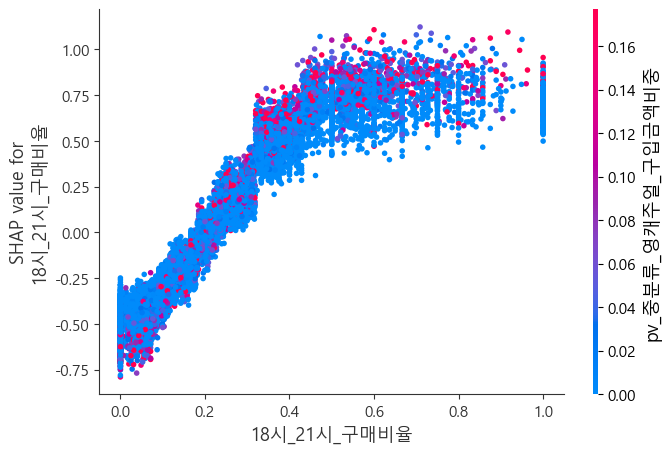

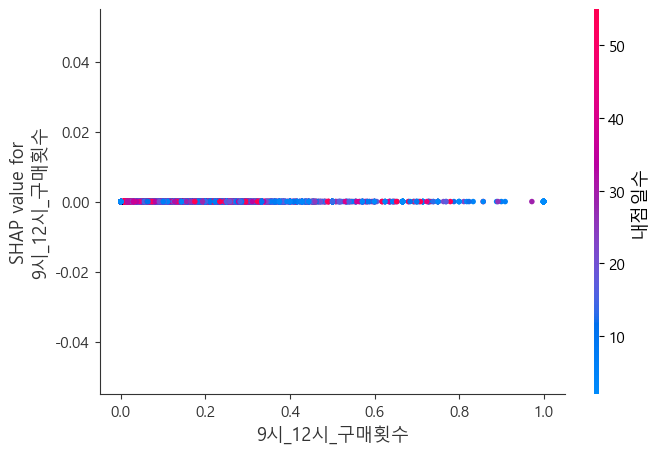

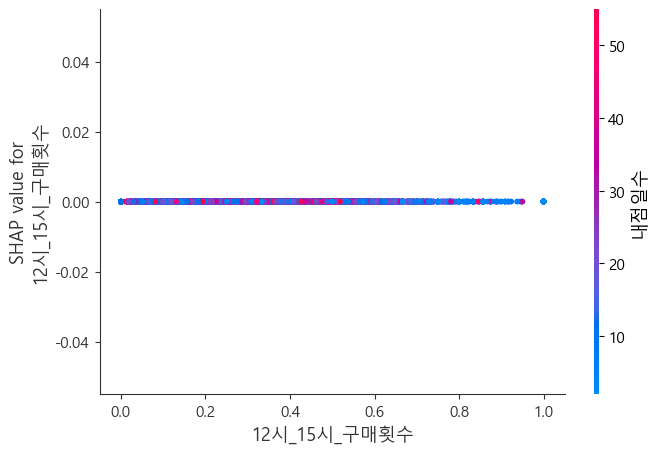

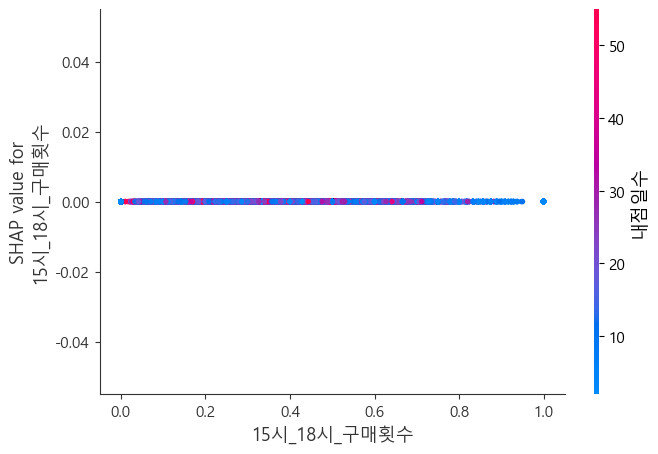

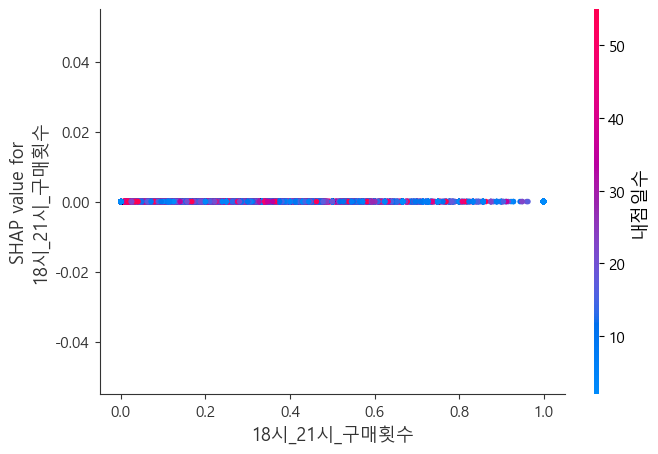

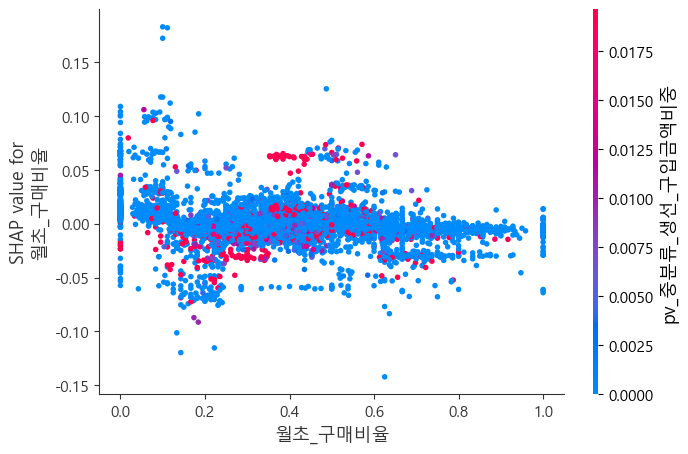

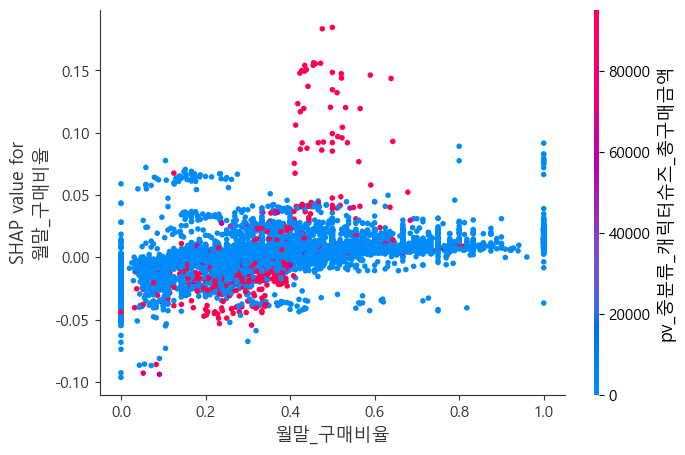

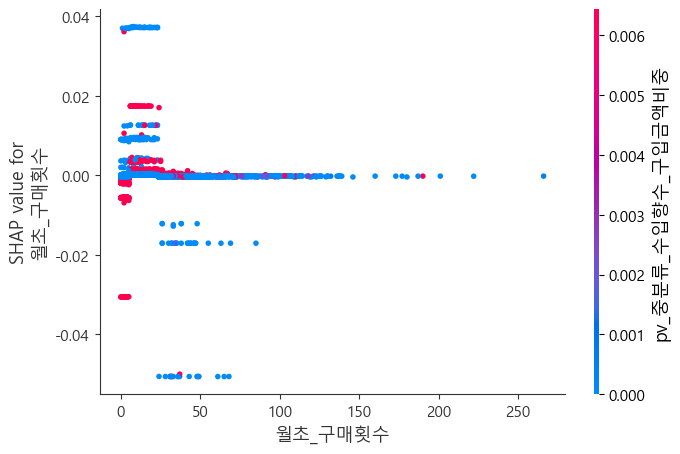

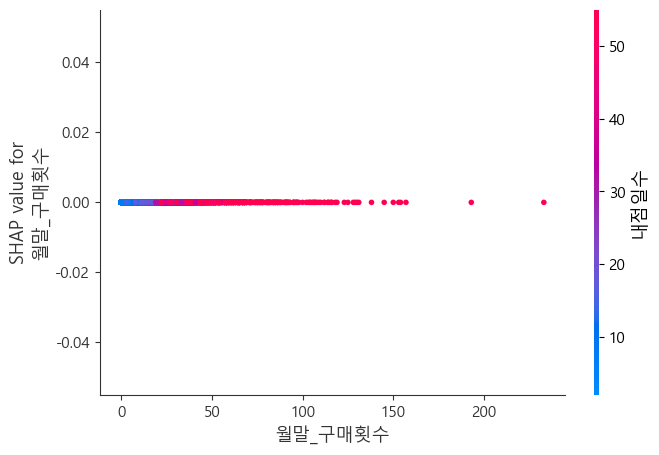

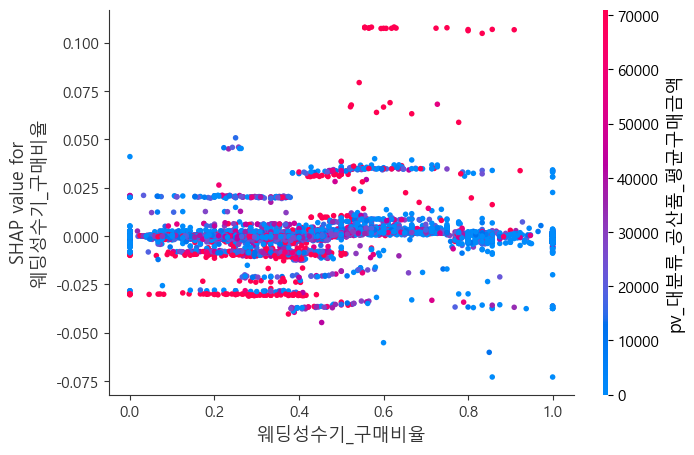

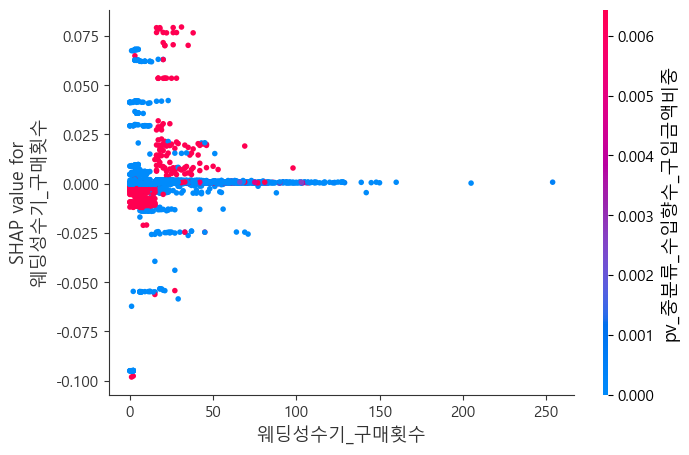

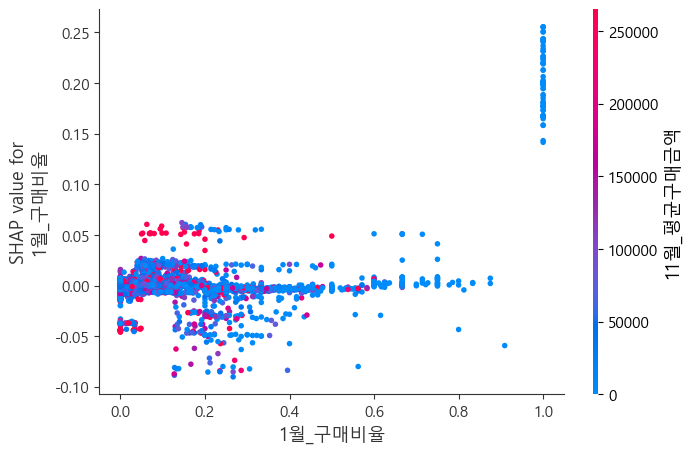

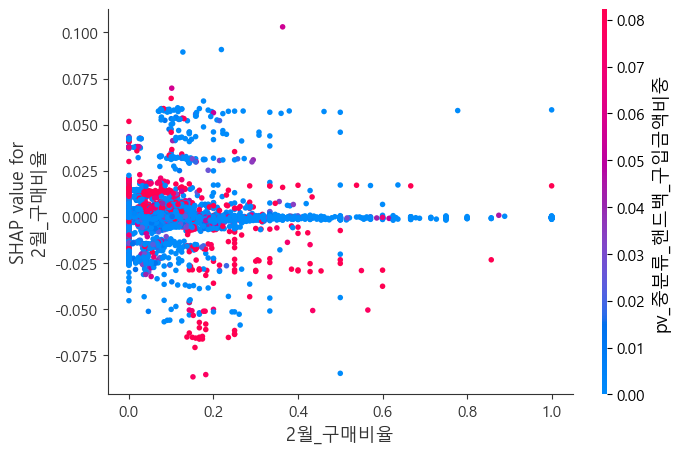

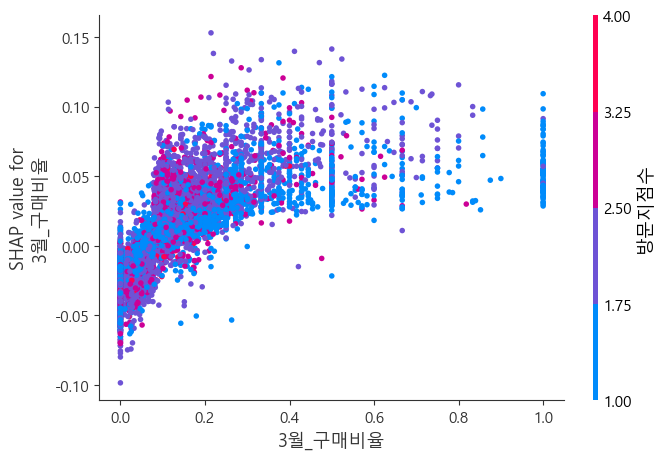

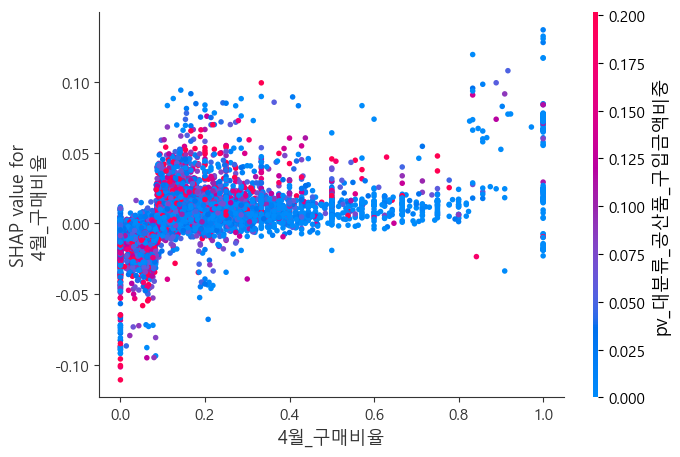

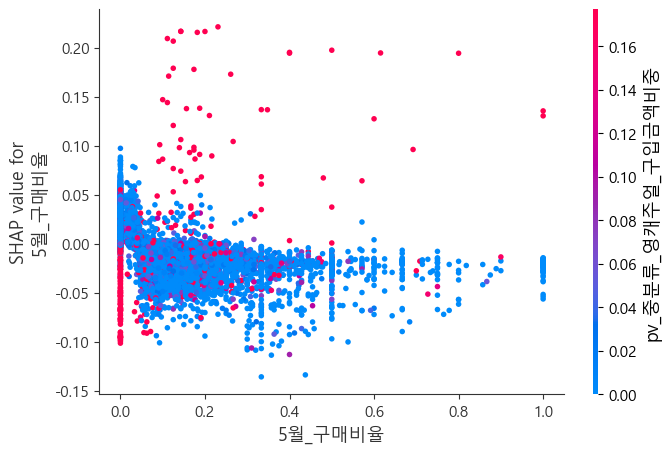

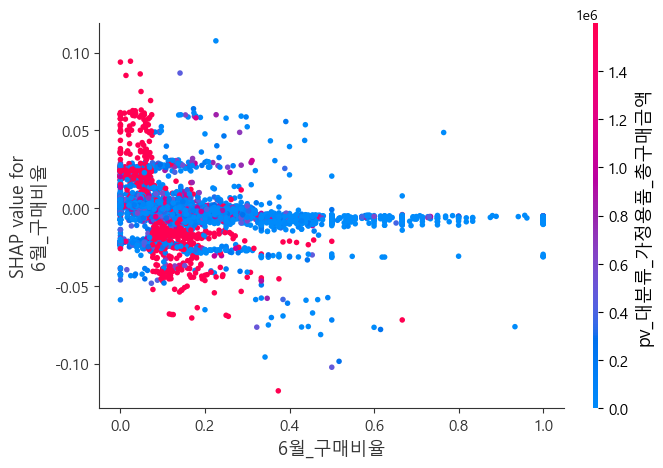

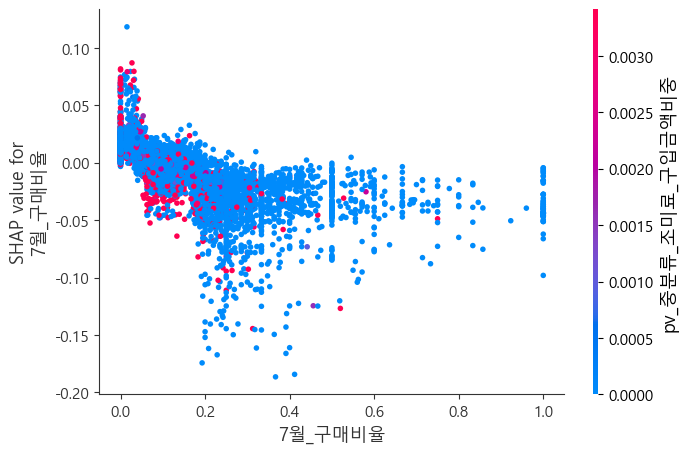

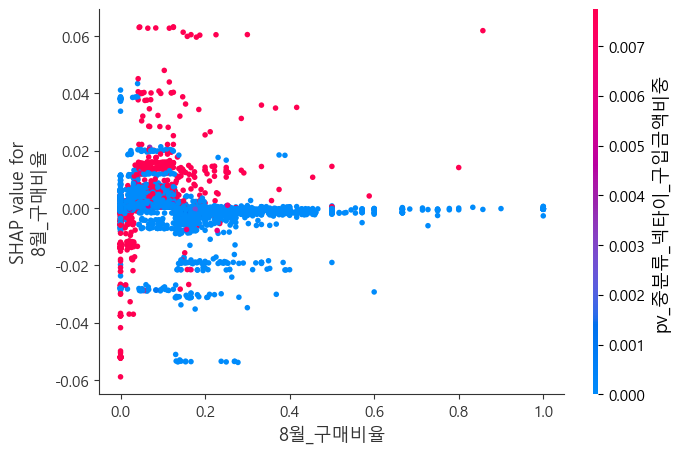

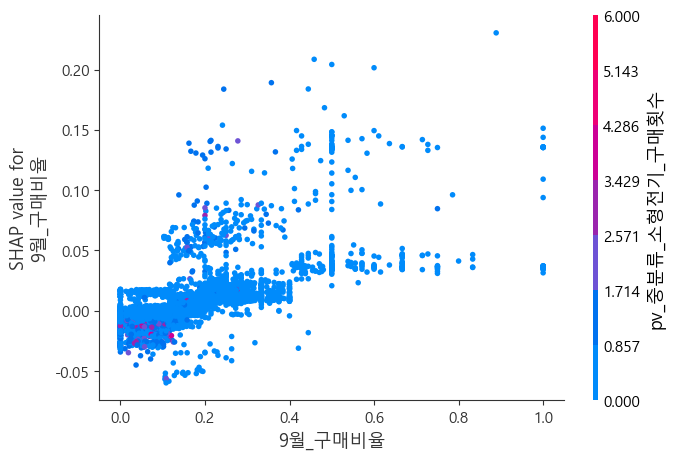

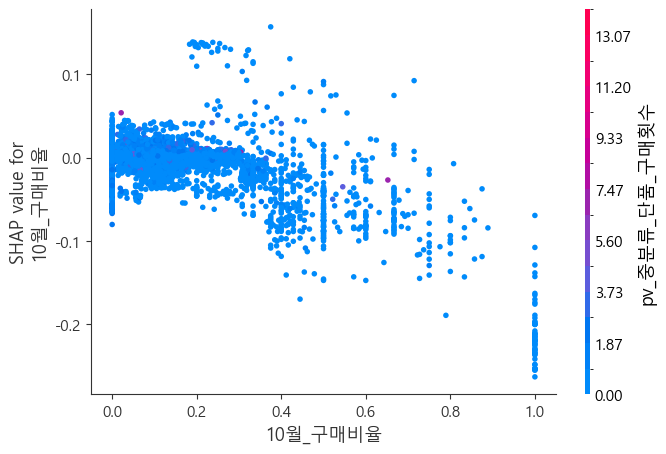

KeyboardInterrupt: 

In [21]:
for col in test_ft.columns:
    shap.dependence_plot(col, shap_values, train_ft, interaction_index= "auto")
    print()

In [49]:
tmp = pd.merge(train_tr, train_target, on= "ID", how= "left")
tmp

ID                 구매일시     지점코드     대분류      중분류  브랜드코드  \
0       train_13219  2004-05-01 09:40:00  A144000   공산품파트       차류   5100   
1        train_5590  2004-05-01 09:40:00  A144000    잡화파트     화장잡화   5101   
2        train_7200  2004-05-01 10:20:00  A112000     공산품     용기보증   5100   
3        train_3010  2004-05-01 10:30:00  A373000  아동_스포츠      아동복   5105   
4       train_10851  2004-05-01 10:30:00  A112000    가정용품  전화기_카세트   5110   
...             ...                  ...      ...     ...      ...    ...   
523100    train_330  2005-04-29 19:53:00  A112000    영캐릭터   트렌드캐주얼   5882   
523101   train_9738  2005-04-29 19:54:00  A373000  아동_스포츠   상품군미지정   5191   
523102  train_10787  2005-04-29 20:00:00  A112000     공산품       음료   5100   
523103  train_13129  2005-04-29 20:00:00  A112000     생식품     용기보증   5100   
523104    train_330  2005-04-29 20:03:00  A112000    영캐릭터   베이직캐주얼   5316   

          구매가격  target  
0        59700     0.0  
1        17000     0.0  
2        34937     0.0  
3        19000     0.0  
4       215000     0.0  
...        ...     ...  
523100  484000     1.0  
523101  144000     0.0  
523102    8340     1.0  
523103   23170     0.0  
523104  506000     1.0  

[523105 rows x 8 columns]

In [50]:
tmp["구매일시"] = pd.to_datetime(tmp["구매일시"])

tmp["구매년"] = tmp["구매일시"].dt.year
tmp["구매월"] = tmp["구매일시"].dt.month
tmp["구매일"] = tmp["구매일시"].dt.day
tmp["구매시"] = tmp["구매일시"].dt.hour

tmp.drop(columns=["구매일시"], inplace= True)

In [51]:
def modification(x):
    if x == "생식품파트":
        ans = "생식품"
    elif x == "공산품파트":
        ans = "공산품"
    elif x == "가정용품파트":
        ans = "가정용품" 
    elif x == "여성캐주얼":
        ans = "여성캐쥬얼"      
    elif x == "잡화파트":
        ans = "잡화"  
    elif x == "로얄부띠끄":
        ans = "로얄부틱"
    else:
        ans = x
    return ans

tmp["대분류"] = tmp["대분류"].apply(modification)

In [52]:
def modi(train_tr):
    train_tr.loc[(train_tr["대분류"] == "아동") & (train_tr["중분류"] == "문구_팬시"), "중분류"] = "문구"

    train_tr.loc[(train_tr["대분류"] == "아동_스포츠") & (train_tr["중분류"] == "완구(문화)"), "중분류"] = "완구"
    train_tr.loc[(train_tr["대분류"] == "아동_스포츠") & (train_tr["중분류"] == "팬시코너(문화)"), "중분류"] = "팬시"
    train_tr.loc[(train_tr["대분류"] == "아동_스포츠") & (train_tr["중분류"] == "아웃도어"), "중분류"] = "아동_아웃도어"
    train_tr.loc[(train_tr["대분류"] == "아동_스포츠") & (train_tr["중분류"] == "단품"), "중분류"] = "아동_단품"
    train_tr.loc[(train_tr["대분류"] == "아동_스포츠") & (train_tr["중분류"] == "수영복"), "중분류"] = "아동_수영복"
    train_tr.loc[(train_tr["대분류"] == "아동_스포츠") & (train_tr["중분류"] == "잡화(문화)"), "중분류"] = "아동_잡화"
    train_tr.loc[(train_tr["대분류"] == "아동_스포츠") & (train_tr["중분류"] == "스포츠웨어"), "중분류"] = "아동_스포츠웨어"
    train_tr.loc[(train_tr["대분류"] == "아동_스포츠") & (train_tr["중분류"] == "스포츠용품"), "중분류"] = "아동_스포츠용품"
    train_tr.loc[(train_tr["대분류"] == "아동_스포츠") & (train_tr["중분류"] == "문구(문화)"), "중분류"] = "문구"
    train_tr.loc[(train_tr["대분류"] == "아동_스포츠") & (train_tr["중분류"] == "스키"), "중분류"] = "아동_스키"

    train_tr.loc[(train_tr["대분류"] == "아동문화") & (train_tr["중분류"] == "문화"), "중분류"] = "아동_문화"

    train_tr.loc[(train_tr["대분류"] == "케주얼_구두_아동") & (train_tr["중분류"] == "트래디셔널"), "중분류"] = "아동_트래디셔널"
    train_tr.loc[(train_tr["대분류"] == "케주얼_구두_아동") & (train_tr["중분류"] == "란제리"), "중분류"] = "아동_란제리"
    train_tr.loc[(train_tr["대분류"] == "케주얼_구두_아동") & (train_tr["중분류"] == "잡화"), "중분류"] = "아동_잡화"
    train_tr.loc[(train_tr["대분류"] == "케주얼_구두_아동") & (train_tr["중분류"] == "단품(트래디셔널)"), "중분류"] = "아동_트래디셔널"
    train_tr.loc[(train_tr["대분류"] == "케주얼_구두_아동") & (train_tr["중분류"] == "셔츠"), "중분류"] = "아동_셔츠"

    train_tr.loc[(train_tr["대분류"] == "잡화") & (train_tr["중분류"] == "패션악세사리"), "중분류"] = "패션ACC"
    train_tr.loc[(train_tr["대분류"] == "잡화") & (train_tr["중분류"] == "헤어악세사리"), "중분류"] = "헤어ACC"
    train_tr.loc[(train_tr["대분류"] == "잡화") & (train_tr["중분류"] == "수입악세사리"), "중분류"] = "수입ACC"

    train_tr.loc[(train_tr["대분류"] == "명품잡화") & (train_tr["중분류"] == "일반악세사리"), "중분류"] = "일반ACC"
    train_tr.loc[(train_tr["대분류"] == "명품잡화") & (train_tr["중분류"] == "헤어액세사리"), "중분류"] = "헤어ACC"
    train_tr.loc[(train_tr["대분류"] == "명품잡화") & (train_tr["중분류"] == "수입액세서리"), "중분류"] = "수입ACC"

    train_tr.loc[(train_tr["대분류"] == "가정용품") & (train_tr["중분류"] == "카세트_전화기"), "중분류"] = "전화기_카세트"
    train_tr.loc[(train_tr["대분류"] == "가정용품") & (train_tr["중분류"] == "냉장고_세탁기"), "중분류"] = "세탁기_냉장고"
    train_tr.loc[(train_tr["대분류"] == "가정용품") & (train_tr["중분류"] == "냉장고.세탁기"), "중분류"] = "세탁기_냉장고"
    train_tr.loc[(train_tr["대분류"] == "가정용품") & (train_tr["중분류"] == "TV.VTR"), "중분류"] = "TV_VTR"
    train_tr.loc[(train_tr["대분류"] == "가정용품") & (train_tr["중분류"] == "취사소형"), "중분류"] = "소형취사가전"
    train_tr.loc[(train_tr["대분류"] == "가정용품") & (train_tr["중분류"] == "원목(주니어)"), "중분류"] = "원목_주니어"
    train_tr.loc[(train_tr["대분류"] == "가정용품") & (train_tr["중분류"] == "쇼파"), "중분류"] = "소파"

    train_tr.loc[(train_tr["대분류"] == "여성의류파트") & (train_tr["중분류"] == "캐릭터캐쥬얼"), "중분류"] = "캐릭터캐주얼"
    train_tr.loc[(train_tr["대분류"] == "여성의류파트") & (train_tr["중분류"] == "영캐쥬얼"), "중분류"] = "영캐주얼"

    train_tr.loc[(train_tr["대분류"] == "남성의류") & (train_tr["중분류"] == "트.단품"), "중분류"] = "단품"
    train_tr.loc[(train_tr["대분류"] == "남성의류") & (train_tr["중분류"] == "내셔널"), "중분류"] = "내셔날"

    train_tr.loc[(train_tr["대분류"] == "스포츠캐쥬얼") & (train_tr["중분류"] == "트레디셔널캐주얼"), "중분류"] = "트래디셔널캐쥬얼"

    train_tr.loc[(train_tr["대분류"] == "여성정장") & (train_tr["중분류"] == "타운"), "중분류"] = "타운웨어"

    train_tr.loc[(train_tr["대분류"] == "여성캐쥬얼") & (train_tr["중분류"] == "타운"), "중분류"] = "타운웨어"

    train_tr.loc[(train_tr["대분류"] == "영플라자") & (train_tr["중분류"] == "진캐주얼"), "중분류"] = "진캐쥬얼"

    train_tr.loc[(train_tr["대분류"] == "영라이브") & (train_tr["중분류"] == "영캐쥬얼"), "중분류"] = "영캐주얼"
    return train_tr

tmp = modi(tmp)

In [53]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
tmp["대분류"] = le.fit_transform(tmp["대분류"])
for i in range(len(le.classes_)):
    print(i, le.classes_[i])

0 가정용품
1 골프_유니캐쥬얼
2 공산품
3 남성의류
4 남성정장스포츠
5 로얄부틱
6 명품잡화
7 생식품
8 스포츠캐쥬얼
9 아동
10 아동_스포츠
11 아동문화
12 여성의류파트
13 여성정장
14 여성캐쥬얼
15 영라이브
16 영어덜트캐쥬얼
17 영캐릭터
18 영플라자
19 잡화
20 케주얼_구두_아동
21 패션잡화


In [54]:
tmp["중분류"] = le.fit_transform(tmp["중분류"])
for i in range(len(le.classes_)):
    print(i, le.classes_[i])

0 DC캐주얼
1 GBR  지원
2 L_B침구
3 NB제화
4 NB핸드백
5 N_B침구
6 TOP디자이너
7 TV_VCR
8 TV_VTR
9 가방
10 가스기기
11 가스렌지
12 가전특정
13 가정잡화
14 건강식품
15 건강용품
16 건식품
17 건어물
18 곡물
19 골프(LC)
20 골프(NB)
21 골프(국내)
22 골프(단품)
23 골프(수입)
24 골프(용품)
25 골프단품
26 골프용품
27 골프웨어
28 과자
29 과자류
30 교복행사
31 구두수선
32 구두임대
33 구두행사
34 국내부띠끄
35 국내종합화장품
36 국내화장품
37 국산화장품
38 그라스
39 기타식품
40 남성구두
41 남성잡화
42 내셔날
43 내의
44 냉난방
45 냉동식품
46 냉장식품
47 넥타이
48 뉴베이직캐주얼
49 니트
50 니트웨어
51 단품
52 단품(트래디셔널)
53 단품_행사
54 단품_행사(캐릭터)
55 단품_행사(트래디셔널)
56 단품_행사1
57 단품_행사2
58 단품행사
59 드레스구두
60 디자이너
61 디자이너니트
62 디자이너부띠끄
63 디자이너숍
64 디자이너캐릭터
65 디자이너캐주얼
66 라디오.카세트
67 라이센스
68 란제리
69 레이디숍A
70 레코드(문화)
71 레포츠
72 레포츠단품
73 로얄
74 로얄부틱2F
75 로얄수입행사
76 마담SIZE
77 마춤
78 머플러
79 면류
80 명품
81 모자
82 모피
83 모피.피혁
84 모피_피혁
85 모피니트
86 문구
87 문구_팬시
88 문화
89 미시케쥬얼
90 미씨캐릭터
91 베이직캐주얼
92 보석
93 부띠끄
94 부띠끄행사
95 브랜드침구
96 비디오
97 사무용품
98 상품개발지원
99 상품군미지정
100 색조화장품
101 생선
102 선글라스
103 선글래스
104 세탁기_냉장고
105 셔츠
106 소파
107 소형가구(가구)
108 소형전기
109 소형취사가전
110 손수건
111 수영복
112 수예
113 수예_인테리어소품
114 수예침장
115 수예행사
116 

In [58]:
tmp["지점코드"] = le.fit_transform(tmp["지점코드"])
for i in range(len(le.classes_)):
    print(i, le.classes_[i])

0 A112000
1 A144000
2 A202000
3 A373000


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16848\489653004.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["지점코드"] = le.fit_transform(tmp["지점코드"])


In [ ]:
# cnt_dict = tmp["지점코드"].value_counts().to_dict()
# tmp["지점코드"] = tmp["지점코드"].map(cnt_dict)

# cnt_dict = tmp["대분류"].value_counts().to_dict()
# tmp["대분류"] = tmp["대분류"].map(cnt_dict)

# cnt_dict = tmp["중분류"].value_counts().to_dict()
# tmp["중분류"] = tmp["중분류"].map(cnt_dict)

In [55]:
tmp = tmp[['ID', '지점코드', '대분류', '중분류', '브랜드코드', '구매가격',  
        '구매년', '구매월', '구매일', '구매시', 'target',]]
tmp

ID     지점코드  대분류  중분류  브랜드코드    구매가격   구매년  구매월  구매일  구매시  \
0       train_13219  A144000    2  228   5100   59700  2004    5    1    9   
1        train_5590  A144000   19  288   5101   17000  2004    5    1    9   
2        train_7200  A112000    2  181   5100   34937  2004    5    1   10   
3        train_3010  A373000   10  161   5105   19000  2004    5    1   10   
4       train_10851  A112000    0  213   5110  215000  2004    5    1   10   
...             ...      ...  ...  ...    ...     ...   ...  ...  ...  ...   
523100    train_330  A112000   17  257   5882  484000  2005    4   29   19   
523101   train_9738  A373000   10   99   5191  144000  2005    4   29   19   
523102  train_10787  A112000    2  191   5100    8340  2005    4   29   20   
523103  train_13129  A112000    7  181   5100   23170  2005    4   29   20   
523104    train_330  A112000   17   91   5316  506000  2005    4   29   20   

        target  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  
...        ...  
523100     1.0  
523101     0.0  
523102     1.0  
523103     0.0  
523104     1.0  

[523105 rows x 11 columns]

In [56]:
tmp.drop(columns= "ID", inplace= True)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16848\1673821889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.drop(columns= "ID", inplace= True)


In [59]:
model.fit(tmp.iloc[:,:-1], tmp["target"])

[LightGBM] [Info] Number of positive: 151531, number of negative: 371574
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 523105, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.289676 -> initscore=-0.896958
[LightGBM] [Info] Start training from score -0.896958


LGBMClassifier(random_state=42)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


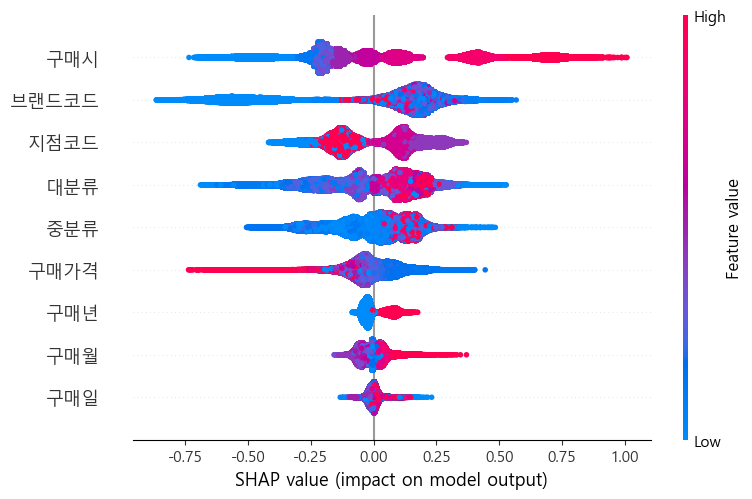

In [38]:
import shap
explainer = shap.TreeExplainer(model)   # 학습 완료된 모델 객체 전달 -> Shapley Value를 계산할 수 있는 객체 생성
shap_values = explainer.shap_values(tmp.iloc[:,:-1]) 
expected_value = explainer.expected_value

shap.summary_plot(shap_values, tmp.iloc[:,:-1])